In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim


def calculate_histogram(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([gray_image], [0], None, [256], [0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def calculate_sharpness(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sharpness = cv2.Laplacian(gray_image, cv2.CV_64F).var()
    return sharpness

def calculate_brightness(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    brightness = np.mean(gray_image)
    return brightness

def calculate_ssim(imageA, imageB):
    grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)
    score, _ = ssim(grayA, grayB, full=True)
    return score

# Path to the folder containing images
folder_path = 'Dataset - train+val+test/train/CNV'

# Load the ideal image
ideal_image = cv2.imread('idealImage.png')

# Resize ideal image for comparison
ideal_image_resized = cv2.resize(ideal_image, (256, 256))

# Get all image file names from the folder
image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Dictionary to track features and check duplicates
image_features = {}
similarities = []
duplicate_images = set()

# Open a CSV file to save results
with open('image_analysis_results.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Image Name', 'Hist. Similarity', 'Sharpness', 'Brightness', 'SSIM', 'Is Duplicate'])

    print("Processing images...")
    for file_name in tqdm(image_files, desc="Progress", ncols=80):  
        image_path = os.path.join(folder_path, file_name)
        image = cv2.imread(image_path)

        if image is None:
            print(f"Skipping unreadable image: {file_name}")
            continue

        # Resize image to match the ideal image
        resized_image = cv2.resize(image, (256, 256))  # Resize to the same size as ideal image

        # Calculate features
        hist_similarity = cv2.compareHist(calculate_histogram(ideal_image_resized), calculate_histogram(resized_image), cv2.HISTCMP_CORREL)
        sharpness = calculate_sharpness(resized_image)
        brightness = calculate_brightness(resized_image)
        ssim_score = calculate_ssim(ideal_image_resized, resized_image)

        # Check if the image is a duplicate (compare with all previous images)
        is_duplicate = False
        for key, features in image_features.items():
            prev_image_path = os.path.join(folder_path, key)
            prev_image = cv2.imread(prev_image_path)

            if prev_image is None:
                continue

            prev_image_resized = cv2.resize(prev_image, (256, 256))

            if calculate_ssim(prev_image_resized, resized_image) > 0.95:  # SSIM threshold for duplicates
                duplicate_images.add(file_name)
                is_duplicate = True
                break

        # Store features for each image
        image_features[file_name] = {
            'hist_similarity': hist_similarity,
            'sharpness': sharpness,
            'brightness': brightness,
            'ssim_score': ssim_score
        }

        similarities.append(hist_similarity)

        # Save the result for the current image into the CSV file
        writer.writerow([file_name, hist_similarity, sharpness, brightness, ssim_score, is_duplicate])

        # Print intermediate result after every 100 images
        if len(similarities) % 100 == 0:
            print(f"Processed {len(similarities)} images...")

# Plot histogram of similarities
plt.hist(similarities, bins=20, color='blue', alpha=0.7)
plt.title('Histogram of Image Similarities to Ideal Image')
plt.xlabel('Similarity Score')
plt.ylabel('Number of Images')
plt.show()

# Print duplicate images
print(f"Duplicate Images: {duplicate_images}")


In [1]:
import cv2
import numpy as np
import os

# Function to calculate sharpness (variance of the Laplacian)
def calculate_sharpness(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sharpness = cv2.Laplacian(gray_image, cv2.CV_64F).var()
    return sharpness

# Function to check brightness (average intensity)
def calculate_brightness(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    brightness = np.mean(gray_image)
    return brightness

# Function to check contrast (standard deviation of intensity)
def calculate_contrast(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    contrast = np.std(gray_image)
    return contrast

# Function to determine if an image is ideal
def is_ideal_image(image, sharpness_threshold=100.0, brightness_range=(50, 200), contrast_threshold=50.0):
    sharpness = calculate_sharpness(image)
    brightness = calculate_brightness(image)
    contrast = calculate_contrast(image)

    is_sharp = sharpness > sharpness_threshold
    is_bright = brightness_range[0] <= brightness <= brightness_range[1]
    is_contrasty = contrast > contrast_threshold

    return is_sharp, is_bright, is_contrasty, sharpness, brightness, contrast

# Path to the folder containing images
folder_path = 'idealImg'

# Get all image file names from the folder
image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Loop through each image and check if it is ideal
for file_name in image_files:
    image_path = os.path.join(folder_path, file_name)
    image = cv2.imread(image_path)

    if image is None:
        print(f"Skipping unreadable image: {file_name}")
        continue

    is_sharp, is_bright, is_contrasty, sharpness, brightness, contrast = is_ideal_image(image)

    print(f"Image: {file_name}")
    print(f"  Sharpness: {sharpness:.2f} (Ideal: {is_sharp})")
    print(f"  Brightness: {brightness:.2f} (Ideal: {is_bright})")
    print(f"  Contrast: {contrast:.2f} (Ideal: {is_contrasty})")

    if is_sharp and is_bright and is_contrasty:
        print("  This image is ideal.\n")
    else:
        print("  This image is not ideal.\n")


Image: Nrml.png
  Sharpness: 3574.56 (Ideal: True)
  Brightness: 128.55 (Ideal: True)
  Contrast: 89.49 (Ideal: True)
  This image is ideal.

Image: DMEimg.png
  Sharpness: 1958.37 (Ideal: True)
  Brightness: 97.70 (Ideal: True)
  Contrast: 71.30 (Ideal: True)
  This image is ideal.

Image: DRUSENimage.png
  Sharpness: 601.97 (Ideal: True)
  Brightness: 64.95 (Ideal: True)
  Contrast: 69.20 (Ideal: True)
  This image is ideal.

Image: CNV.png
  Sharpness: 1244.97 (Ideal: True)
  Brightness: 83.32 (Ideal: True)
  Contrast: 72.79 (Ideal: True)
  This image is ideal.



Processing file: Before preprocessing analysis csv/Normalimage_analysis_results.csv
Summary statistics for Normalimage_analysis_results.csv
       Hist. Similarity     Sharpness   Brightness         SSIM
count       1341.000000   1341.000000  1341.000000  1341.000000
mean           0.338886   1717.944165    45.696832     0.179138
std            0.159548   1367.416889    16.490061     0.067989
min            0.041925    351.865764    18.348038     0.013056
25%            0.203010   1046.840064    35.146225     0.127033
50%            0.321315   1355.196559    41.602249     0.182022
75%            0.463829   1968.659152    51.829514     0.226767
max            0.775620  19447.265133   149.242599     0.371277


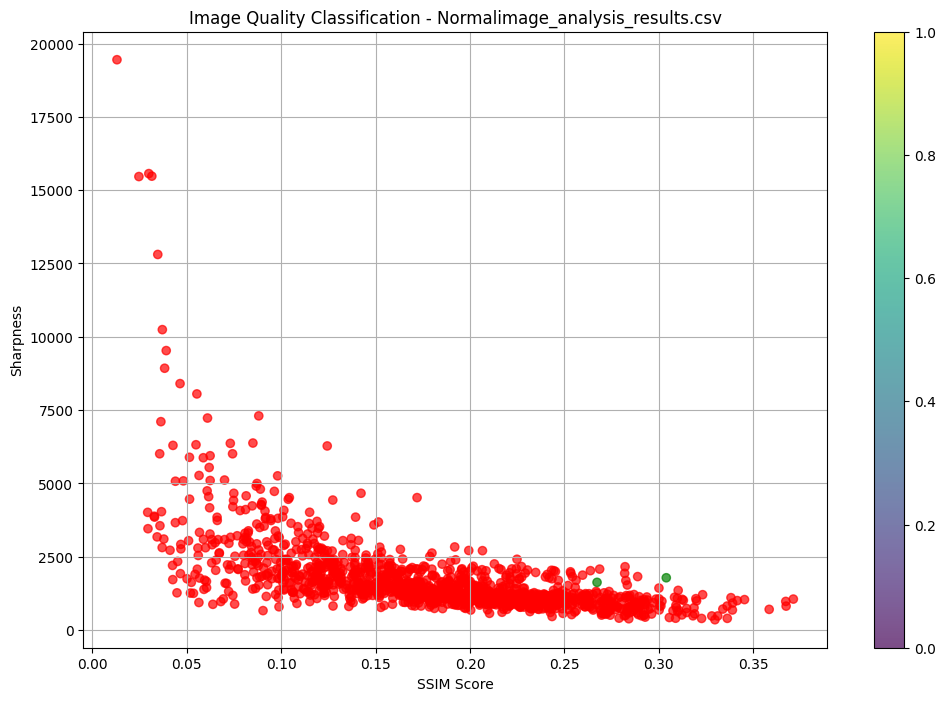

Total Good Images in Normalimage_analysis_results.csv: 2
Total Bad Images in Normalimage_analysis_results.csv: 1339
Processing file: Before preprocessing analysis csv/DMEimage_analysis_results.csv
Summary statistics for DMEimage_analysis_results.csv
       Hist. Similarity     Sharpness   Brightness         SSIM
count       1315.000000   1315.000000  1315.000000  1315.000000
mean           0.582562   1579.903010    50.060209     0.067616
std            0.147922   1373.758223    19.927699     0.010455
min            0.089983     70.157888    14.746109     0.026099
25%            0.489783    888.241704    35.659576     0.061433
50%            0.599693   1260.049234    45.136459     0.068536
75%            0.709396   1824.789820    59.679138     0.074783
max            0.833078  19318.076769   147.429001     0.100093


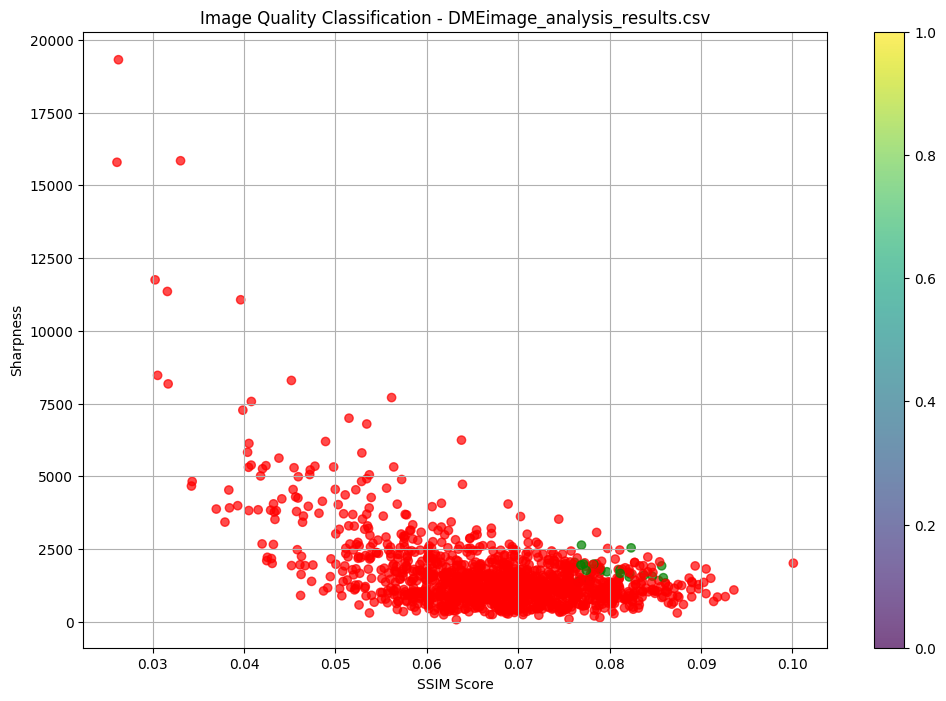

Total Good Images in DMEimage_analysis_results.csv: 20
Total Bad Images in DMEimage_analysis_results.csv: 1295
Processing file: Before preprocessing analysis csv/DRUSENimage_analysis_results.csv
Summary statistics for DRUSENimage_analysis_results.csv
       Hist. Similarity     Sharpness   Brightness         SSIM
count       2129.000000   2129.000000  2129.000000  2129.000000
mean           0.243847   1898.665413    49.340976     0.088588
std            0.273263   1308.945823    18.504817     0.019246
min           -0.011403    392.030070    21.162918     0.036856
25%            0.050551   1175.032550    37.246841     0.074828
50%            0.072260   1529.558156    44.673416     0.087174
75%            0.475753   2148.494864    55.300217     0.099530
max            0.914899  17293.676089   165.576035     0.175356


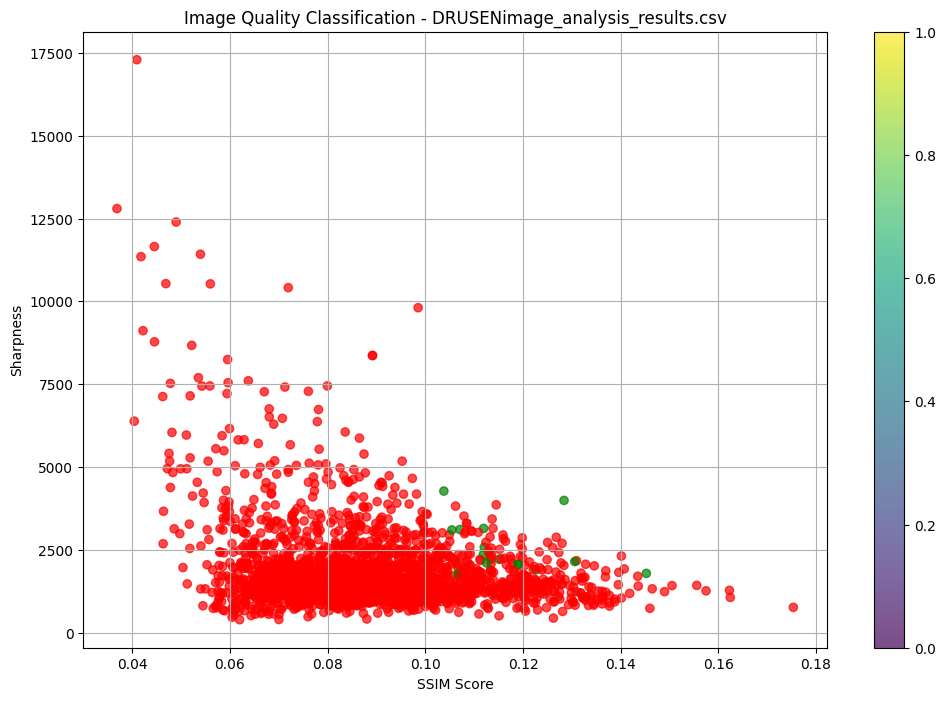

Total Good Images in DRUSENimage_analysis_results.csv: 16
Total Bad Images in DRUSENimage_analysis_results.csv: 2113
Processing file: Before preprocessing analysis csv/CNVimage_analysis_results.csv
Summary statistics for CNVimage_analysis_results.csv
       Hist. Similarity     Sharpness   Brightness         SSIM
count       2720.000000   2720.000000  2720.000000  2720.000000
mean           0.444614   2307.576577    51.185559     0.241700
std            0.193290   1936.857256    20.218642     0.083474
min           -0.062473    311.388277    17.985214     0.028422
25%            0.333033   1259.691711    36.979866     0.178702
50%            0.459016   1772.113710    46.008736     0.249512
75%            0.591406   2578.836906    59.413956     0.305164
max            0.852590  23347.455658   164.505676     0.449982


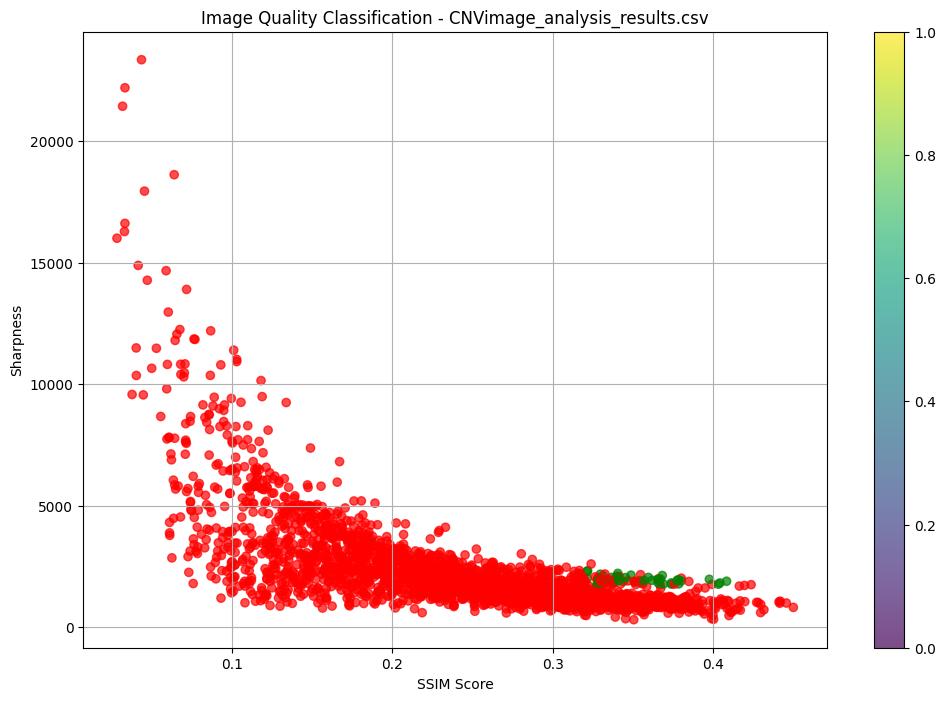

Total Good Images in CNVimage_analysis_results.csv: 41
Total Bad Images in CNVimage_analysis_results.csv: 2679


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Directory containing all your CSV files
csv_dir = 'Before preprocessing analysis csv'

# Loop through all CSV files in the directory
for csv_file in os.listdir(csv_dir):
    if csv_file.endswith('.csv'):
        file_path = os.path.join(csv_dir, csv_file)
        print(f"Processing file: {file_path}")
        
        # Load the CSV data
        df = pd.read_csv(file_path)

        # Check the distribution of each feature
        print("Summary statistics for", csv_file)
        print(df.describe())

        # Automatically adjust thresholds based on percentiles of the data
        hist_similarity_threshold = np.percentile(df['Hist. Similarity'], 80)  # Top 20% for histogram similarity
        sharpness_threshold = np.percentile(df['Sharpness'], 50)  # Median sharpness
        brightness_min = np.percentile(df['Brightness'], 10)  # Bottom 10% for brightness
        brightness_max = np.percentile(df['Brightness'], 90)  # Top 10% for brightness
        ssim_threshold = np.percentile(df['SSIM'], 80)  # Top 20% for SSIM

        # Classify each image as "good" or "bad" based on the new thresholds
        def classify_image(row):
            hist_good = row['Hist. Similarity'] >= hist_similarity_threshold
            sharpness_good = row['Sharpness'] >= sharpness_threshold
            brightness_good = brightness_min <= row['Brightness'] <= brightness_max
            ssim_good = row['SSIM'] >= ssim_threshold

            # Image is "good" if it satisfies all conditions
            return 'Good' if hist_good and sharpness_good and brightness_good and ssim_good else 'Bad'

        # Apply the classification to the DataFrame
        df['Classification'] = df.apply(classify_image, axis=1)

        # Plotting
        plt.figure(figsize=(12, 8))

        # Assign colors based on classification
        colors = df['Classification'].map({'Good': 'green', 'Bad': 'red'})

        # Scatter plot with SSIM vs Sharpness
        plt.scatter(df['SSIM'], df['Sharpness'], c=colors, alpha=0.7)

        # Label the axes
        plt.title(f'Image Quality Classification - {csv_file}')
        plt.xlabel('SSIM Score')
        plt.ylabel('Sharpness')

        # Show the plot
        plt.colorbar()
        plt.grid(True)
        plt.show()

        # Optionally, you can print out a summary
        good_images = df[df['Classification'] == 'Good'].shape[0]
        bad_images = df[df['Classification'] == 'Bad'].shape[0]

        print(f"Total Good Images in {csv_file}: {good_images}")
        print(f"Total Bad Images in {csv_file}: {bad_images}")


Summary of combined data:
       Hist. Similarity     Sharpness   Brightness         SSIM
count       7505.000000   7505.000000  7505.000000  7505.000000
mean           0.392940   1958.721191    49.484382     0.156585
std            0.239140   1609.399240    19.157244     0.094287
min           -0.062473     70.157888    14.746109     0.013056
25%            0.172672   1118.454559    36.550171     0.076891
50%            0.413872   1523.953110    44.618118     0.117540
75%            0.592049   2203.573184    56.845520     0.229735
max            0.914899  23347.455658   165.576035     0.449982


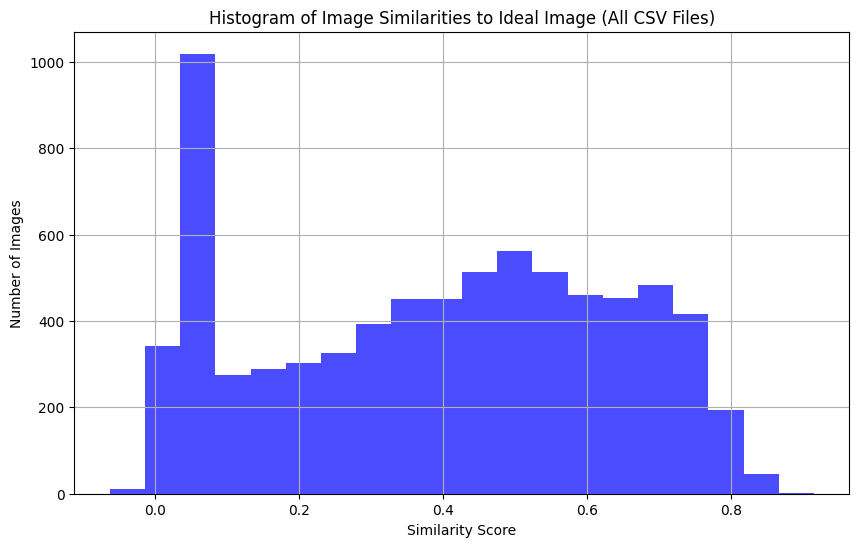

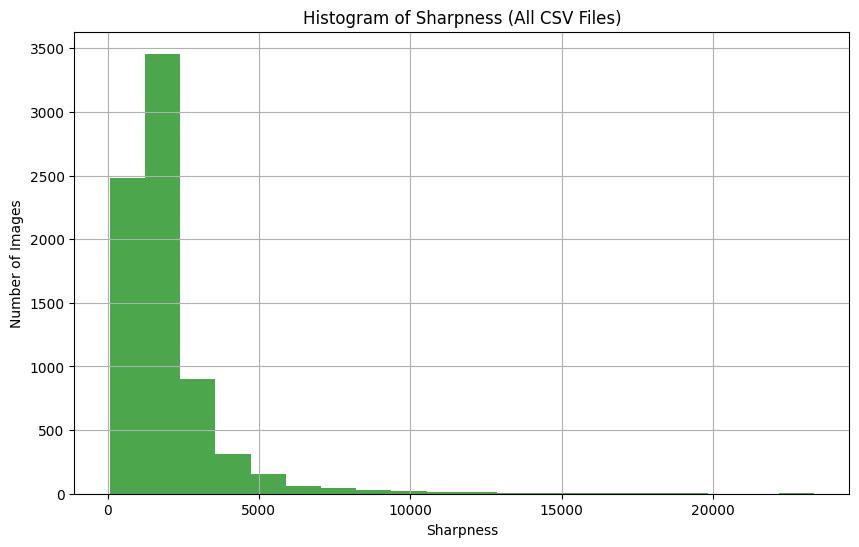

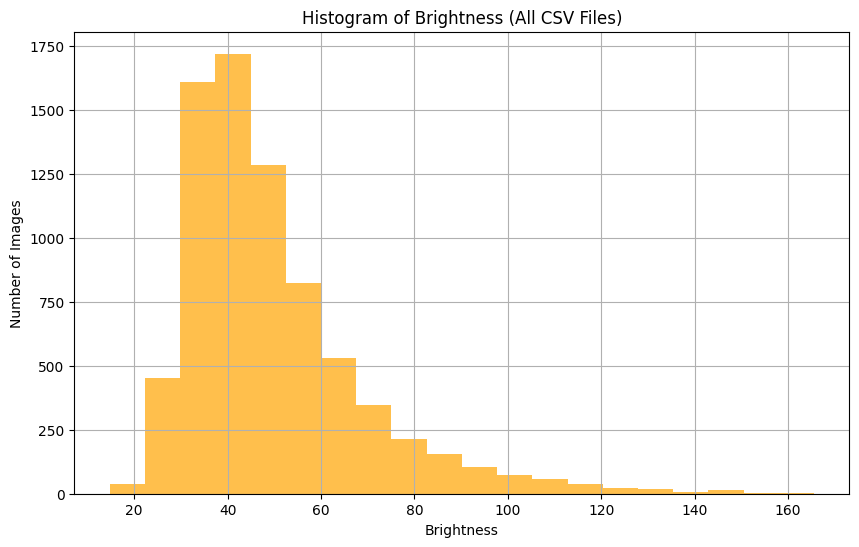

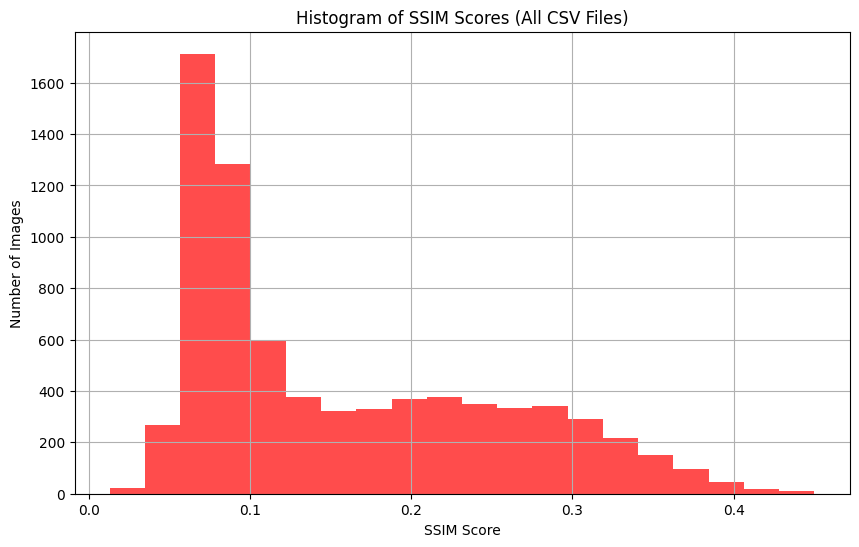

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Directory containing all your CSV files
csv_dir = 'Before preprocessing analysis csv'

# Initialize an empty DataFrame to hold data from all CSV files
all_data = pd.DataFrame()

# Loop through all CSV files in the directory
for csv_file in os.listdir(csv_dir):
    if csv_file.endswith('.csv'):
        file_path = os.path.join(csv_dir, csv_file)
        df = pd.read_csv(file_path)
        all_data = pd.concat([all_data, df], ignore_index=True)

# Check the combined data
print("Summary of combined data:")
print(all_data.describe())

# Plot a histogram of Histogram Similarity for all images
plt.figure(figsize=(10, 6))
plt.hist(all_data['Hist. Similarity'], bins=20, color='blue', alpha=0.7)
plt.title('Histogram of Image Similarities to Ideal Image (All CSV Files)')
plt.xlabel('Similarity Score')
plt.ylabel('Number of Images')
plt.grid(True)
plt.show()

# Plot a histogram of Sharpness for all images
plt.figure(figsize=(10, 6))
plt.hist(all_data['Sharpness'], bins=20, color='green', alpha=0.7)
plt.title('Histogram of Sharpness (All CSV Files)')
plt.xlabel('Sharpness')
plt.ylabel('Number of Images')
plt.grid(True)
plt.show()

# Plot a histogram of Brightness for all images
plt.figure(figsize=(10, 6))
plt.hist(all_data['Brightness'], bins=20, color='orange', alpha=0.7)
plt.title('Histogram of Brightness (All CSV Files)')
plt.xlabel('Brightness')
plt.ylabel('Number of Images')
plt.grid(True)
plt.show()

# Plot a histogram of SSIM for all images
plt.figure(figsize=(10, 6))
plt.hist(all_data['SSIM'], bins=20, color='red', alpha=0.7)
plt.title('Histogram of SSIM Scores (All CSV Files)')
plt.xlabel('SSIM Score')
plt.ylabel('Number of Images')
plt.grid(True)
plt.show()



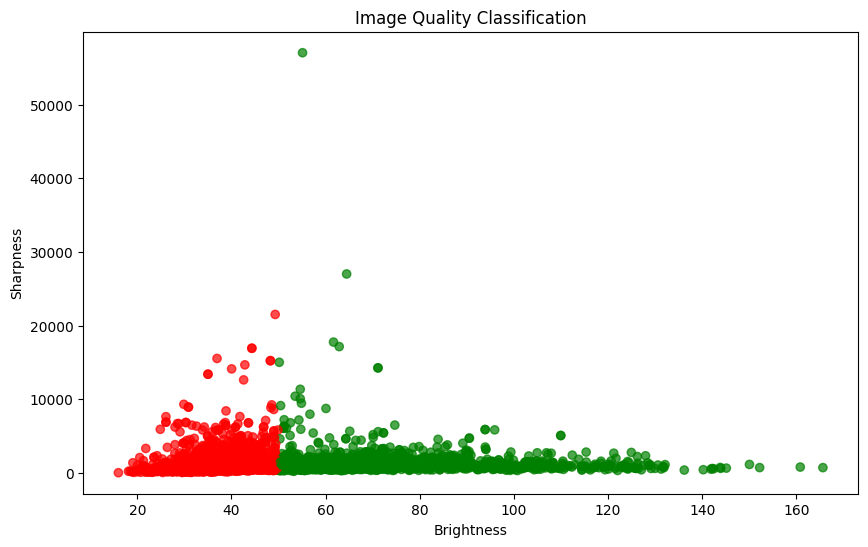

Total Good Images: 2026
Total Bad Images: 3300


In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Directories
main_dir = '/home/sheena.mittal.22cse/DIP/Dataset - train+val+test'  # Replace with your main directory path
sub_dirs = ['train', 'val', 'test']
classes = ['CNV', 'DRUSEN', 'DME', 'NORMAL']

# Parameters for classification
sharpness_threshold = 100  
brightness_min = 50       
brightness_max = 400       
    

# Function to calculate sharpness
def calculate_sharpness(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

# Function to calculate brightness
def calculate_brightness(image):
    return np.mean(image)

# Function to calculate noise (simple approximation using variance)
def calculate_noise(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return np.var(gray)

# Classify image based on criteria
def classify_image(sharpness, brightness):
    sharpness_good = sharpness >= sharpness_threshold
    brightness_good = brightness_min <= brightness <= brightness_max
    

    return 'Good' if sharpness_good and brightness_good else 'Bad'

# Store results
results = []

# Iterate over the dataset
for sub_dir in sub_dirs:
    for label in classes:
        image_folder = os.path.join(main_dir, sub_dir, label)
        for filename in os.listdir(image_folder):
            img_path = os.path.join(image_folder, filename)
            image = cv2.imread(img_path)

            if image is not None:
                # Calculate parameters
                sharpness = calculate_sharpness(image)
                brightness = calculate_brightness(image)
                

                # Classify the image
                classification = classify_image(sharpness, brightness)

                # Append results
                results.append({
                    'Image': filename,
                    'Set': sub_dir,
                    'Class': label,
                    'Sharpness': sharpness,
                    'Brightness': brightness,
                    'Classification': classification
                })

# Convert results to DataFrame
df_results = pd.DataFrame(results)

# Save results to CSV
df_results.to_csv('image_classification.csv', index=False)

# Plot the classification results
plt.figure(figsize=(10, 6))
colors = df_results['Classification'].map({'Good': 'green', 'Bad': 'red'})
plt.scatter(df_results['Brightness'], df_results['Sharpness'], c=colors, alpha=0.7)
plt.title('Image Quality Classification')
plt.xlabel('Brightness')
plt.ylabel('Sharpness')
plt.show()

# Print summary
good_images = df_results[df_results['Classification'] == 'Good'].shape[0]
bad_images = df_results[df_results['Classification'] == 'Bad'].shape[0]

print(f"Total Good Images: {good_images}")
print(f"Total Bad Images: {bad_images}")
